In [291]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [292]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [293]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, clear_output

def validate_with_optical_flow(input_path, model, device, output_dir='valid_frames',
                             threshold=0.5, mag_threshold=2.5, 
                             max_frames=100):
    """
    Validate segmentation consistency using optical flow between consecutive masks
    """
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(input_path)
    
    model.eval()
    frame_count = 0
    prev_mask = None
    valid_frames = []
    validation_metrics = []
    
    # For visualization
    plt.figure(figsize=(18, 6))
    
    with torch.no_grad():
        while cap.isOpened() and frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break
                
            # Convert and predict
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_tensor = torch.from_numpy(frame_gray/255.).unsqueeze(0).unsqueeze(0).float().to(device)
            pred = model(frame_tensor)
            curr_mask = (pred > threshold).squeeze().cpu().numpy().astype(np.uint8)
            
            metrics = {
                'frame': frame_count,
                'mean_magnitude': 0,
                'angle_std': 0,
                'is_valid': False,
                'mask_area': np.sum(curr_mask)
            }
            
            if prev_mask is not None:
                # Ensure masks are suitable for optical flow
                prev_mask_flow = (prev_mask * 255).astype(np.uint8)
                curr_mask_flow = (curr_mask * 255).astype(np.uint8)
                
                # Compute optical flow BETWEEN MASKS
                flow = cv2.calcOpticalFlowFarneback(
                    prev_mask_flow, curr_mask_flow,
                    None, 0.5, 3, 15, 3, 5, 1.2, 0
                )
                
                # Get flow only within current mask region
                y, x = np.where(curr_mask == 1)
                if len(y) > 0:
                    flow_vectors = flow[y, x]
                    magnitude, angle = cv2.cartToPolar(flow_vectors[...,0], flow_vectors[...,1])
                    
                    mean_mag = np.mean(magnitude)
                
                    
                    metrics.update({
                        'mean_magnitude': mean_mag,
                        'is_valid': (mean_mag <= mag_threshold) 
                    })
                    
                    if metrics['is_valid']:
                        valid_frames.append(frame_count)
                
                validation_metrics.append(metrics)
                
                # Visualization
                plt.clf()
                
                # Panel 1: Original frame with masks
                plt.subplot(1, 3, 1)
                plt.imshow(frame_rgb)
                plt.imshow(prev_mask, alpha=0.3, cmap='Blues')
                plt.imshow(curr_mask, alpha=0.3, cmap='Reds')
                plt.title(f'Frame {frame_count}\nBlue:Prev, Red:Curr')
                plt.axis('off')
                
                # Panel 2: Optical flow field
                plt.subplot(1, 3, 2)
                hsv = np.zeros((*curr_mask.shape, 3), dtype=np.uint8)
                if len(y) > 0:
                    mag_norm = cv2.normalize(np.sqrt(flow[...,0]**2 + flow[...,1]**2), None, 0, 255, cv2.NORM_MINMAX)
                    hsv[...,0] = np.arctan2(flow[...,1], flow[...,0]) * 180/np.pi/2
                    hsv[...,1] = 255
                    hsv[...,2] = mag_norm
                plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
                plt.title('Optical Flow Between Masks')
                plt.axis('off')
                
                # Panel 3: Flow vectors
                plt.subplot(1, 3, 3)
                plt.imshow(frame_gray, cmap='gray')
                if len(y) > 50:
                    step = len(y)//50
                    plt.quiver(x[::step], y[::step], 
                               flow_vectors[::step,0], -flow_vectors[::step,1],
                               color='cyan', scale=10, width=0.003)
                plt.title('Flow Vectors on LV')
                plt.axis('off')
                
                plt.tight_layout()
                clear_output(wait=True)
                display(plt.gcf())
                
                # Save valid frames
                if metrics['is_valid']:
                    plt.savefig(os.path.join(output_dir, f'valid_{frame_count:04d}.png'), dpi=120)
            
            prev_mask = curr_mask.copy()
            frame_count += 1
    
    cap.release()
    plt.close()
    
    # Generate comprehensive report
    valid_count = len(valid_frames)
    total_compared = max(1, len(validation_metrics))
    
    report = f"""
    ====== OPTICAL FLOW VALIDATION REPORT ======
    
    Input: {input_path}
    Frames Processed: {frame_count}
    Frames Compared: {total_compared}
    
    Validation Criteria:
      - Minimum Flow Magnitude: {mag_threshold}
    
    Results:
      - Valid Frames: {valid_count} ({valid_count/total_compared:.1%})
      - Discarded Frames: {total_compared - valid_count}
    
    Valid Frames Statistics:
      - Mean Flow Magnitude: {np.mean([m['mean_magnitude'] for m in validation_metrics if m['is_valid']]):.2f}
      - Mean Mask Area: {np.mean([m['mask_area'] for m in validation_metrics if m['is_valid']]):.0f} px
    
    Valid Frame Indices: {valid_frames}
    """
    
    print(report)
    with open(os.path.join(output_dir, 'validation_report.txt'), 'w') as f:
        f.write(report)
    
    return valid_frames, validation_metrics

In [294]:
from src.model import UNet

model = UNet()
model.load_state_dict(torch.load('../u-net/models/best_unet.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [295]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [296]:
device

device(type='cpu')

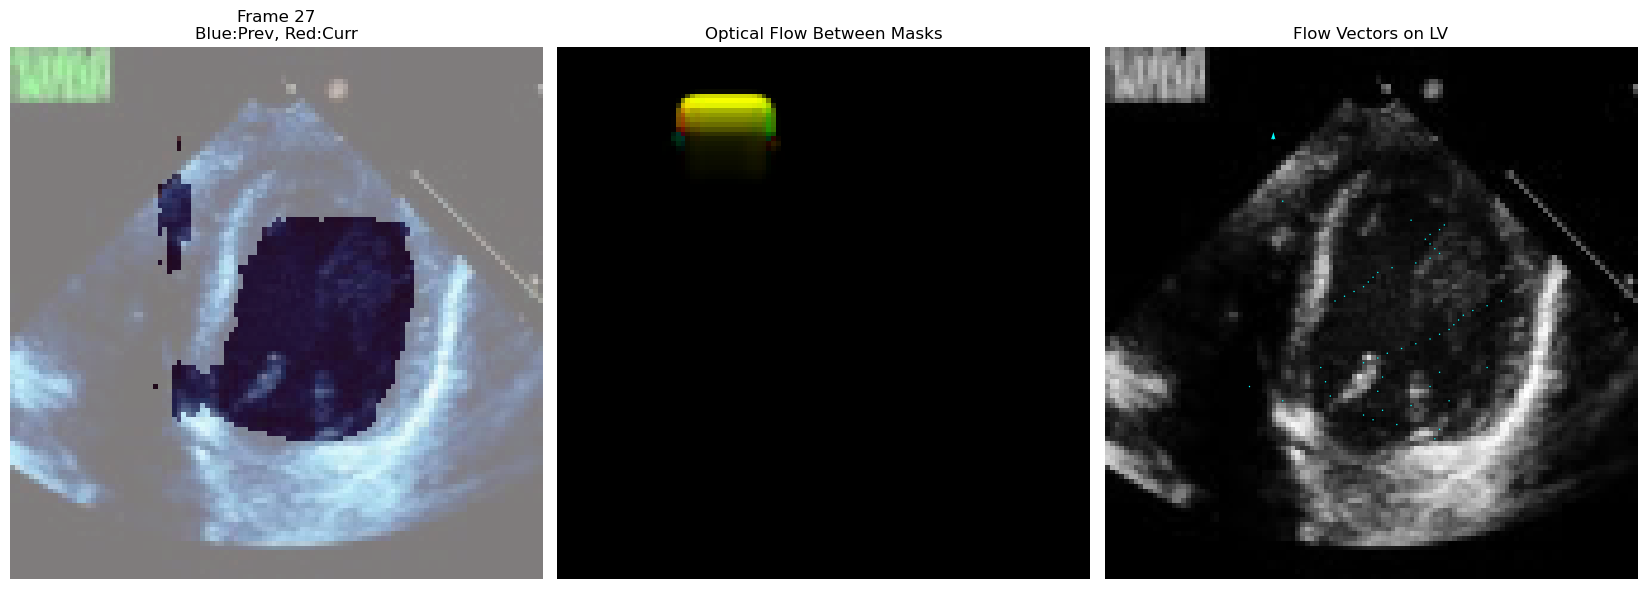


    ====== OPTICAL FLOW VALIDATION REPORT ======
    
    Input: ../data/raw/A4C/videos/CR32a7558-CR3dcb1d0-000054.avi
    Frames Processed: 28
    Frames Compared: 27
    
    Validation Criteria:
      - Minimum Flow Magnitude: 2.5
    
    Results:
      - Valid Frames: 21 (77.8%)
      - Discarded Frames: 6
    
    Valid Frames Statistics:
      - Mean Flow Magnitude: 1.22
      - Mean Mask Area: 1114 px
    
    Valid Frame Indices: [1, 2, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26, 27]
    


([1, 2, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26, 27],
 [{'frame': 1,
   'mean_magnitude': 0.9888621,
   'angle_std': 0,
   'is_valid': True,
   'mask_area': 1743},
  {'frame': 2,
   'mean_magnitude': 1.9691949,
   'angle_std': 0,
   'is_valid': True,
   'mask_area': 1419},
  {'frame': 3,
   'mean_magnitude': 2.7886486,
   'angle_std': 0,
   'is_valid': False,
   'mask_area': 908},
  {'frame': 4,
   'mean_magnitude': 1.1106197,
   'angle_std': 0,
   'is_valid': True,
   'mask_area': 784},
  {'frame': 5,
   'mean_magnitude': 1.0747293,
   'angle_std': 0,
   'is_valid': True,
   'mask_area': 746},
  {'frame': 6,
   'mean_magnitude': 0.7458782,
   'angle_std': 0,
   'is_valid': True,
   'mask_area': 819},
  {'frame': 7,
   'mean_magnitude': 1.2077944,
   'angle_std': 0,
   'is_valid': True,
   'mask_area': 985},
  {'frame': 8,
   'mean_magnitude': 1.0739355,
   'angle_std': 0,
   'is_valid': True,
   'mask_area': 1010},
  {'frame': 9,
   'mean_magnitude': 1.1978159

In [297]:
validate_with_optical_flow("../data/raw/A4C/videos/CR32a7558-CR3dcb1d0-000054.avi", model, device)